**1. Import Libraries and Tools**

In [1]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from sklearn.utils import shuffle  # For shuffling the data

2025-10-18 17:46:48.023005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760809608.195376      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760809608.247446      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**2. Load Datasets**

In [2]:
# Directories for training and testing data
train_dir = '/kaggle/input/images/MRI Images/Training/'
test_dir = '/kaggle/input/images/MRI Images/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

**3. Data Visualization**

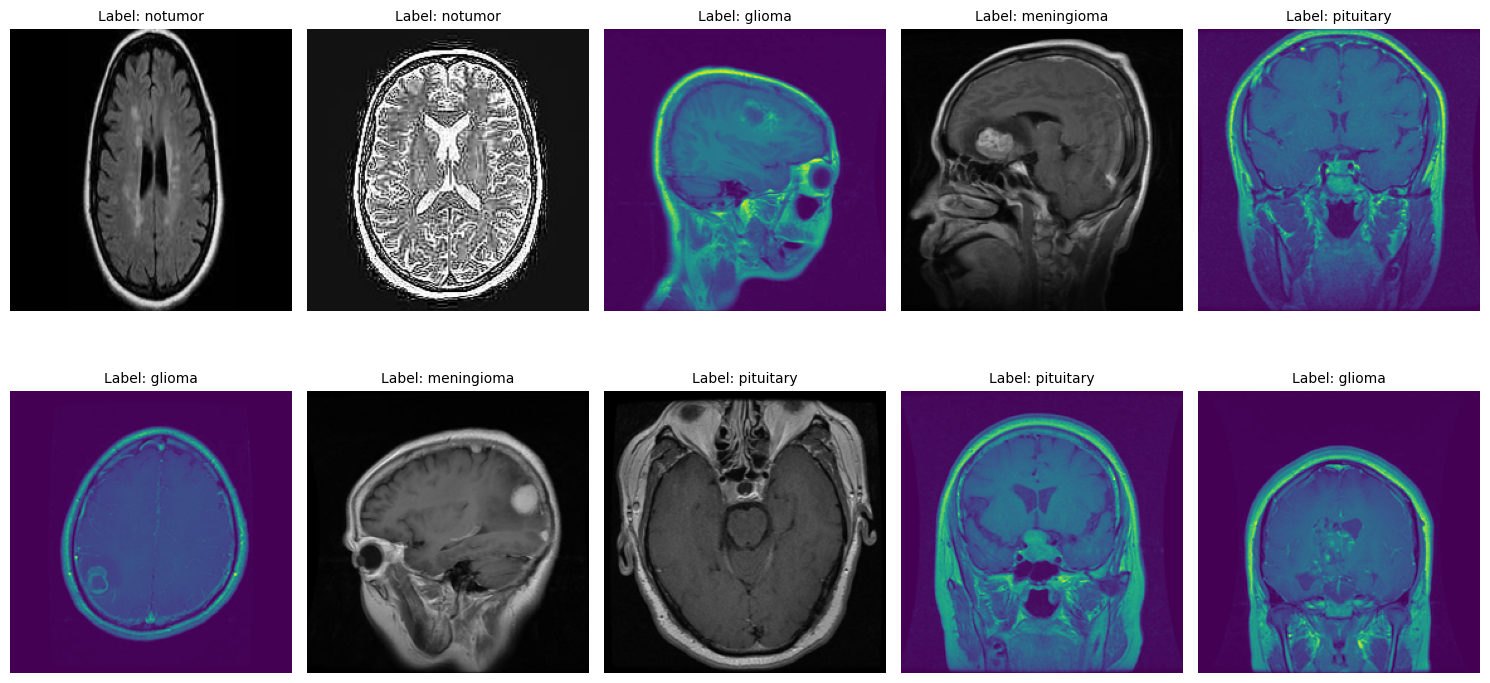

In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


**4. Image Preprocessing**

In [4]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

**5. Building Model Architecture**

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/kaggle/input/images/MRI Images/Training"
test_dir = "/kaggle/input/images/MRI Images/Testing"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Save label mapping
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

# Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_generator, epochs=5, validation_data=test_generator)

# Save model & labels
model.save("brain_tumor_model.h5")

import pickle
with open("class_labels.pkl", "wb") as f:
    pickle.dump(class_labels, f)

model.summary()



Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1760809622.945966      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1760809626.397507     109 service.cc:148] XLA service 0x7fb708008d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760809626.398193     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760809626.673126     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/179 ━━━━━━━━━━━━━━━━━━━━ 14:11 5s/step - accuracy: 0.3125 - loss: 1.3732

I0000 00:00:1760809629.158942     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 176ms/step - accuracy: 0.5835 - loss: 1.0498 - val_accuracy: 0.7849 - val_loss: 0.5319
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.8580 - loss: 0.3965 - val_accuracy: 0.8467 - val_loss: 0.3737
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9102 - loss: 0.2596 - val_accuracy: 0.9123 - val_loss: 0.2295
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9348 - loss: 0.1916 - val_accuracy: 0.9130 - val_loss: 0.2157
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9521 - loss: 0.1299 - val_accuracy: 0.9413 - val_loss: 0.1589


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,178,510 (84.60 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,785,674 (56.40 MB)

**6. Plots**

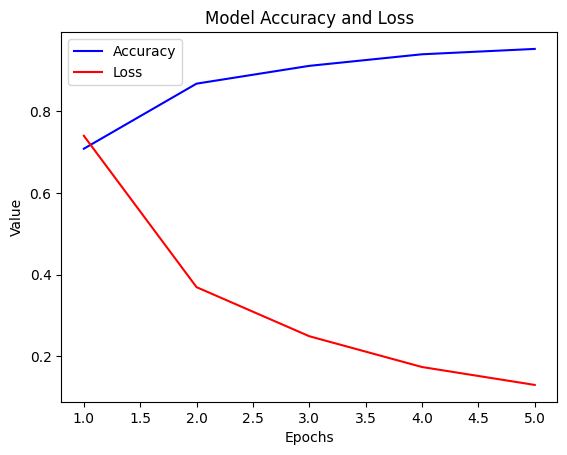

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], 'b-', label='Accuracy')
plt.plot(epochs, history.history['loss'], 'r-', label='Loss')

plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


**7. Model Classification Report**

In [7]:
from sklearn.metrics import classification_report
import numpy as np

# IMPORTANT: Make sure test_generator has shuffle=False to align labels correctly
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict class probabilities for the test set
y_pred_probs = model.predict(test_generator)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class label names in order
class_names = list(test_generator.class_indices.keys())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.93      0.93       300
  meningioma       0.91      0.83      0.87       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



**8. Model Confusion Matrix Plotting**

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


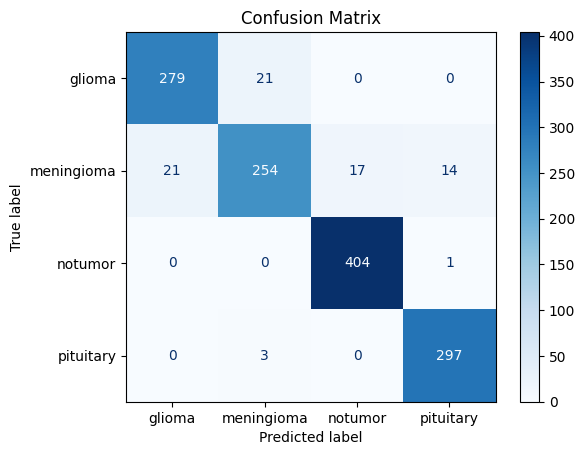

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make sure test_generator is defined with shuffle=False
# test_generator = test_datagen.flow_from_directory(..., shuffle=False)

# Predict classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


**9. Saving the Model**

In [9]:
model.save('model.h5') 

**10. Testing the Model**

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load model
model = load_model("brain_tumor_model.h5")

# Load labels
with open("class_labels.pkl", "rb") as f:
    class_labels = pickle.load(f)

def detect_and_display(image_path, model):
    # Load and preprocess
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    confidence_score = np.max(predictions)
    
    result = class_labels[predicted_class_index]
    
    # Show image
    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(f"{result} ({confidence_score*100:.2f}%)")
    plt.show()


**11. Example Usage**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


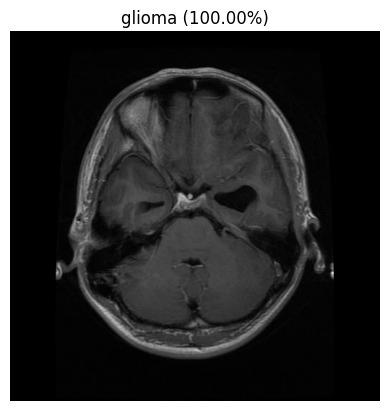

In [11]:
# Exampleg
image_path = "/kaggle/input/images/MRI Images/Testing/glioma/Te-glTr_0004.jpg"
detect_and_display(image_path, model)